In [1]:
import pandas as pd
import json
import os
import context_window_helper as cwh

In [2]:
filepath = r"C:\Users\gluzk\source\repos\CS2_cheat_detection\Data_Conversion_Pipeline\test_data\0"

# Loading csv tick data as a pd.DataFrame
match_ticks = pd.read_parquet(path=filepath+".parquet")

# Loading json event data a list of tuples (str, pd.Dataframe)
def json_2_eventlist(filepath:str) -> list:   
    with open(filepath, "r") as f:
        json_data = json.load(f)

    data = []       

    for key, value in json_data.items():
        if isinstance(value, list):
            df = pd.DataFrame(value)
            data.append((key, df))

    return data

match_events = json_2_eventlist(filepath=filepath+".json")

In [3]:
ticks_before_kill = 896
tick_after_kill = 128

context_window_vals = ["attacker_X", "attacker_Y", "attacker_Z", "attacker_vel_X", "attacker_vel_Y", "attacker_vel_Z", "attacker_pitch", "attacker_yaw", "attacker_pitch_delta", 
                       "attacker_yaw_delta", "attacker_pitch_head_delta", "attacker_yaw_head_delta", "attacker_flashed", "attacker_shot", "attacker_kill", "is_kill_through_smoke", 
                       "is_kill_wallbang", "attacker_midair", "attacker_weapon_knife", "attacker_weapon_auto_rifle", "attacker_weapon_semi_rifle", "attacker_weapon_pistol",
                       "attacker_weapon_grenade", "attacker_weapon_smg", "attacker_weapon_shotgun",
                       "victim_X", "victim_Y", "victim_Z", "victim_health", "victim_noise", "map_dust2", "map_mirage", "map_inferno", "map_train",
                       "map_nuke", "map_ancient", "map_vertigo", "map_anubis", "map_office", "map_overpass", "map_basalt", "map_edin", "map_italy", "map_thera", "map_mills"]

In [25]:
match_events[36][1]["user_name"]

0      Player_9
1      Player_8
2     Player_10
3      Player_6
4      Player_7
        ...    
79     Player_9
80     Player_7
81    Player_10
82     Player_8
83     Player_5
Name: user_name, Length: 84, dtype: object

In [5]:
match_ticks

,inventory,usercmd_input_history,inventory_as_ids,approximate_spotted_by,aim_punch_angle_vel,aim_punch_angle,active_weapon_ammo,item_def_idx,weapon_quality,entity_lvl,...,usercmd_forward_move,usercmd_consumed_server_angle_changes,is_alive,velocity_Z,active_weapon_name,usercmd_mouse_dx,game_time,tick,steamid,name
0,"[knife_t, Glock-18]",[],"[59, 4]",[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",0.0,59.0,0.0,1.0,...,NaN,NaN,True,NaN,knife_t,NaN,51.187500,1,Player_8,Player_8
1,"[knife_t, Glock-18, AK-47]",[],"[59, 4, 7]",[],"[0.0, 0.0, 0.0]","[0.4380251467227936, 0.01679001934826374, 0.0]",30.0,7.0,4.0,1.0,...,NaN,NaN,True,NaN,AK-47,NaN,51.187500,1,Player_9,Player_9
2,"[knife_t, Glock-18]",[],"[59, 4]",[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",20.0,4.0,4.0,1.0,...,NaN,NaN,True,NaN,Glock-18,NaN,51.187500,1,Player_7,Player_7
3,"[knife, USP-S]",[],"[42, 61]",[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,NaN,NaN,True,NaN,knife,NaN,51.187500,1,Player_4,Player_4
4,[],[],[],[Player_3],"[0.0, 0.0, 0.0]","[-36.0, 0.0, -27.0]",NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,None,NaN,51.187500,1,Player_10,Player_10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601785,[],"[{'player_tick_count': 63464, 'player_tick_fra...",[],[],"[0.0, 0.0, 0.0]","[-0.6168899536132812, 0.0, 0.0]",NaN,NaN,NaN,NaN,...,0.0,0.0,False,0.0,None,0.0,991.703125,60194,Player_10,Player_10
601786,[],"[{'player_tick_count': 58461, 'player_tick_fra...",[],[],"[0.0, 0.0, 0.0]","[-4.232666969299316, 0.0, 0.0]",NaN,NaN,NaN,NaN,...,0.0,0.0,False,0.0,None,0.0,991.703125,60194,Player_1,Player_1
601787,[],"[{'player_tick_count': 63357, 'player_tick_fra...",[],[],"[-149.81370544433594, 14.492167472839355, 0.0]","[0.0, 0.0, 0.0]",NaN,NaN,NaN,NaN,...,0.0,0.0,False,0.0,None,0.0,991.703125,60194,Player_5,Player_5
601788,[],"[{'player_tick_count': 59411, 'player_tick_fra...",[],[],"[-2.8513312339782715, -0.37512412667274475, 0.0]","[-36.0, 0.0, -27.0]",NaN,NaN,NaN,NaN,...,0.0,0.0,False,0.0,None,0.0,991.703125,60194,Player_2,Player_2


In [6]:
print(match_ticks["yaw"].min())
print(match_ticks["yaw"].max())

-180.0
179.99933


In [7]:
MDP = cwh.MatchDataProcessor(match_ticks)

In [20]:
player = "Player_3"
player_death_idx = -1


for idx, event in enumerate(match_events):
    if event[0] == "player_death":
        player_death_idx = idx
        break


player_deaths = MDP.get_player_kills(match_events, player, player_death_idx)
start_ticks, end_ticks = MDP.get_context_window_ticks(player_deaths, ticks_before_kill, tick_after_kill)

context_window = pd.DataFrame(columns=context_window_vals)

for i in range(12, len(start_ticks)):
    context_window["attacker_X"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "X")
    context_window["attacker_Y"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "Y")
    context_window["attacker_Z"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "Z")

    context_window["attacker_vel_X"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_X")
    context_window["attacker_vel_Y"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_Y")
    context_window["attacker_vel_Z"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_Z")

    context_window["attacker_pitch"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "pitch")
    context_window["attacker_yaw"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "yaw")
    context_window["attacker_pitch_delta"] = MDP.get_pitch_yaw_deltas("pitch", start_ticks[i], end_ticks[i], player)
    context_window["attacker_yaw_delta"] = MDP.get_pitch_yaw_deltas("yaw", start_ticks[i], end_ticks[i], player)

    context_window["attacker_pitch_head_delta"], context_window["attacker_yaw_head_delta"] = MDP.get_pitch_yaw_head_deltas(start_ticks[i], end_ticks[i], player, player_deaths.iloc[i]["user_name"])
    

    break # Remove later, currently used for testing
print(context_window.iloc[896]["attacker_yaw_head_delta"])
context_window.iloc[896]["attacker_pitch_head_delta"]

-0.43084610471896667


7.963550176316346

In [21]:
player_deaths.iloc[12]

assistedflash                               False
assister_name                                    
assister_steamid                                 
attacker_name                            Player_3
attacker_steamid                         Player_3
attackerblind                               False
attackerinair                               False
distance                                31.663618
dmg_armor                                      12
dmg_health                                    143
dominated                                       0
headshot                                     True
hitgroup                                     head
noreplay                                     True
noscope                                     False
penetrated                                      1
revenge                                         0
thrusmoke                                   False
tick                                        41223
user_name                                Player_6


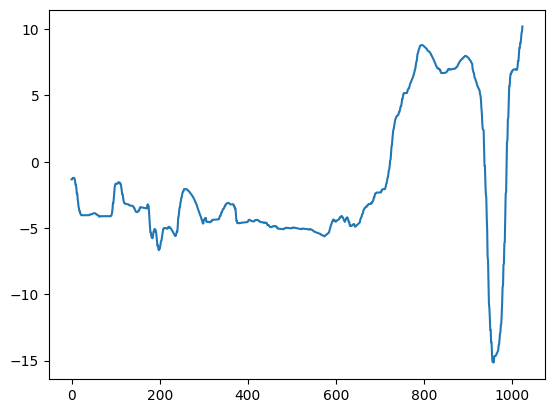

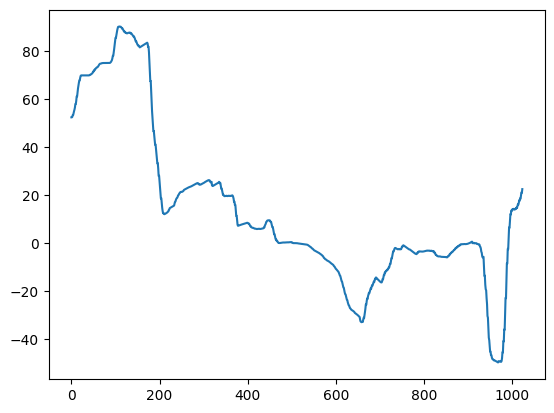

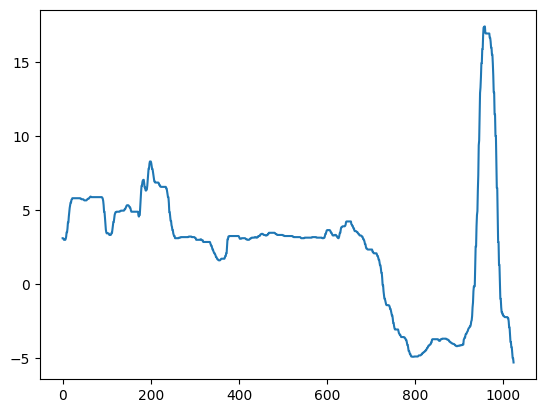

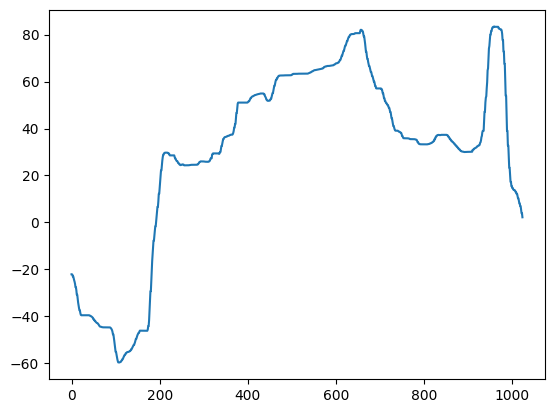

In [22]:
import matplotlib.pyplot as plt

plt.plot(context_window["attacker_pitch_head_delta"])
plt.show()

plt.plot(context_window["attacker_yaw_head_delta"])
plt.show()

plt.plot(context_window["attacker_pitch"])
plt.show()

plt.plot(context_window["attacker_yaw"])
plt.show()

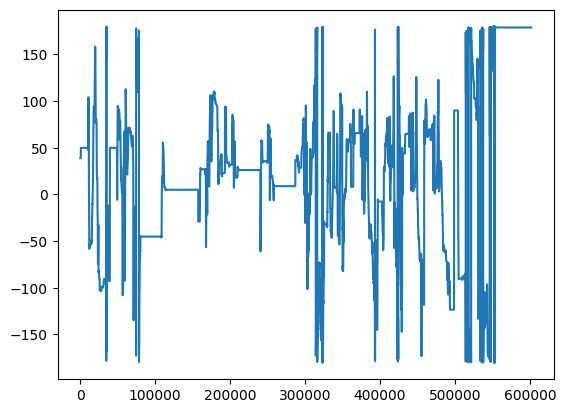

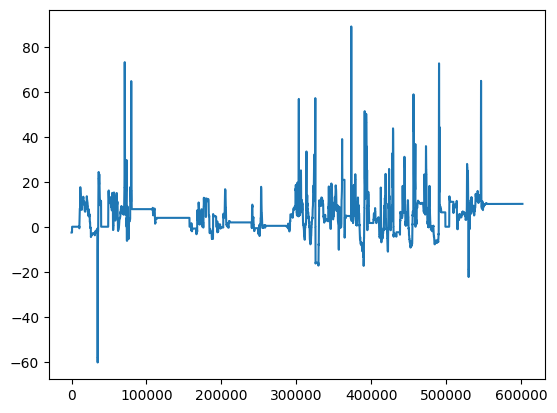

In [13]:
plt.plot(match_ticks[match_ticks["name"] == "Player_3"]["yaw"])
plt.show()

plt.plot(match_ticks[match_ticks["name"] == "Player_3"]["pitch"])
plt.show()